## File: onet_task_adjacency.ipynb
#### Summary: Explores ONET data to motivate th Agentic AI model

#### By: Peyman Shahidi
#### Created: Jan 15, 2025

<br>

In [226]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import combinations
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [227]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [228]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

### Main Code Starts Here

<br>

## Section (1)

In [229]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# keep occupation, task, work activity, and detailed work activity columns
onet = onet[['occ_code', 'occ_title', 'dwa_id', 'dwa_title']]
onet = onet.sort_values(by=['occ_code', 'dwa_id']).reset_index(drop=True)

# add industry column
onet['ind'] = onet['occ_code'].apply(lambda x: x.split('-')[0] if '-' in x else x)

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [230]:
# Filter rows that contain "Teachers" (case-insensitive)
contains_teacher = onet[onet['occ_title'].str.contains('Teachers', case=False, na=False)]

# Step 2: Get the number of unique occupations containing "Teacher"
unique_teacher_occupations = contains_teacher['occ_title'].nunique()
print(f'Number of unique occupations containing the word "Teachers": {unique_teacher_occupations}')

# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

Number of unique occupations containing the word "Teachers": 50


In [231]:
# remove duplicates
print(f"Number of rows before removing duplicates: {len(onet)}")
onet = onet.drop_duplicates(subset=['ind', 'occ_code', 'dwa_id']).reset_index(drop=True)
print(f"Number of rows after removing duplicates: {len(onet)}")

onet

Number of rows before removing duplicates: 22650
Number of rows after removing duplicates: 15785


,occ_code,occ_title,dwa_id,dwa_title,ind
0,11-1011,Chief Executives,4.A.1.a.1.I03.D06,Conduct hearings to investigate legal issues.,11
1,11-1011,Chief Executives,4.A.1.a.1.I10.D06,Identify environmental concerns.,11
2,11-1011,Chief Executives,4.A.1.a.1.I18.D03,Conduct research on social issues.,11
3,11-1011,Chief Executives,4.A.1.a.1.I20.D04,Conduct research to gain information about pro...,11
4,11-1011,Chief Executives,4.A.1.b.1.I02.D01,Identify opportunities for green initiatives.,11
...,...,...,...,...,...
15780,53-7121,"Tank Car, Truck, and Ship Loaders",4.A.3.b.4.I08.D06,Maintain material moving equipment in good wor...,53
15781,53-7121,"Tank Car, Truck, and Ship Loaders",4.A.3.b.6.I08.D03,Record operational or production data.,53
15782,53-7121,"Tank Car, Truck, and Ship Loaders",4.A.4.a.2.I03.D16,Communicate with others to coordinate material...,53
15783,53-7121,"Tank Car, Truck, and Ship Loaders",4.A.4.b.4.I12.D21,Direct maintenance or repair activities.,53


In [232]:
print(f"Number of unique industries: {len(onet['ind'].unique())}")
print(f"Number of unique occupations: {len(onet['occ_code'].unique())}")
print(f"Number of unique tasks: {len(onet['dwa_id'].unique())}")

Number of unique industries: 22
Number of unique occupations: 742
Number of unique tasks: 2081


In [233]:
# get frequency of tasks per industry
ind_task_freq = (
    onet
    .groupby(['ind', 'dwa_id', 'dwa_title'])
    .size()
    .reset_index(name='occupation_count')
    .sort_values(by=['ind', 'occupation_count'], ascending=[True, False])
    .reset_index(drop=True)
)

# keep only tasks that appear in multiple occupations
ind_task_freq = ind_task_freq[ind_task_freq['occupation_count'] > 1].reset_index(drop=True)
print(f"Number of unique tasks per industry (occupation_count > 1): {len(ind_task_freq)}")

ind_task_freq = ind_task_freq.sort_values(by=['ind', 'occupation_count', 'dwa_id'], ascending=[True, False, False]).reset_index(drop=True)
ind_task_freq.to_csv(f'{output_data_path}/ind_task_freq.csv', index=False)

Number of unique tasks per industry (occupation_count > 1): 2235


In [234]:
ind_task_freq

,ind,dwa_id,dwa_title,occupation_count
0,11,4.A.4.b.4.I01.D13,Supervise employees.,24
1,11,4.A.4.c.2.I01.D03,Hire personnel.,22
2,11,4.A.4.b.3.I04.D16,Conduct employee training programs.,22
3,11,4.A.2.b.4.I01.D01,Develop organizational policies or programs.,21
4,11,4.A.4.b.4.I09.D04,Prepare operational budgets.,20
...,...,...,...,...
2230,53,4.A.1.b.2.I06.D11,Inspect items for damage or defects.,2
2231,53,4.A.1.b.2.I05.D07,Inspect facilities.,2
2232,53,4.A.1.b.2.I05.D03,"Inspect facilities, equipment or supplies to e...",2
2233,53,4.A.1.a.2.I04.D02,Time vehicle speed or traffic-control equipmen...,2


In [235]:
# repetitive common tasks across industries
ind_common_tasks = (
    ind_task_freq
    .groupby(['dwa_id', 'dwa_title'])  # Fixed: use existing column names
    .size()
    .reset_index(name='industry_count')
)

# keep only tasks appearing in multiple industries
ind_common_tasks = ind_common_tasks[ind_common_tasks['industry_count'] > 1].reset_index(drop=True)

print(f"Number of common tasks across industries (industry_count > 1): {len(ind_common_tasks)}")

# save common tasks sorted by frequency
ind_common_tasks = ind_common_tasks.sort_values(
    by=['industry_count', 'dwa_id'], ascending=[False, True]
).reset_index(drop=True)

ind_common_tasks.to_csv(f'{output_data_path}/ind_common_tasks.csv', index=False)

Number of common tasks across industries (industry_count > 1): 207


In [236]:
# Create occupation-task set
occ_tasks = onet.groupby(['ind', 'occ_code'])['dwa_id'].apply(set).reset_index()

results = []

# Loop over each industry
for industry, group in occ_tasks.groupby('ind'):
    occupations = group['occ_code'].tolist()
    task_sets = group['dwa_id'].tolist()

    # Loop over all occupation pairs
    for (occ_a, tasks_a), (occ_b, tasks_b) in combinations(zip(occupations, task_sets), 2):
        intersection = tasks_a & tasks_b
        if intersection:
            similarity = 0.5 * (len(intersection) / len(tasks_a) + len(intersection) / len(tasks_b))
            results.append({
                'ind': industry,
                'occ_a': occ_a,
                'occ_b': occ_b,
                'tasks_a': len(tasks_a),
                'tasks_b': len(tasks_b),
                'common_tasks': len(intersection),
                'similarity_score': similarity
            })

# Create results DataFrame
similarity_df = pd.DataFrame(results)

# # Filter out pairs with small similarity scores
# similarity_df = similarity_df[similarity_df['similarity_score'] > 0.4].reset_index(drop=True)

# Sort by highest similarity
similarity_df = similarity_df.sort_values(
    by=['ind', 'similarity_score', 'occ_a'], ascending=[True, False, False]
).reset_index(drop=True)

# See top pairs per industry
similarity_df.to_csv(f'{output_data_path}/occupation_task_similarity.csv', index=False)

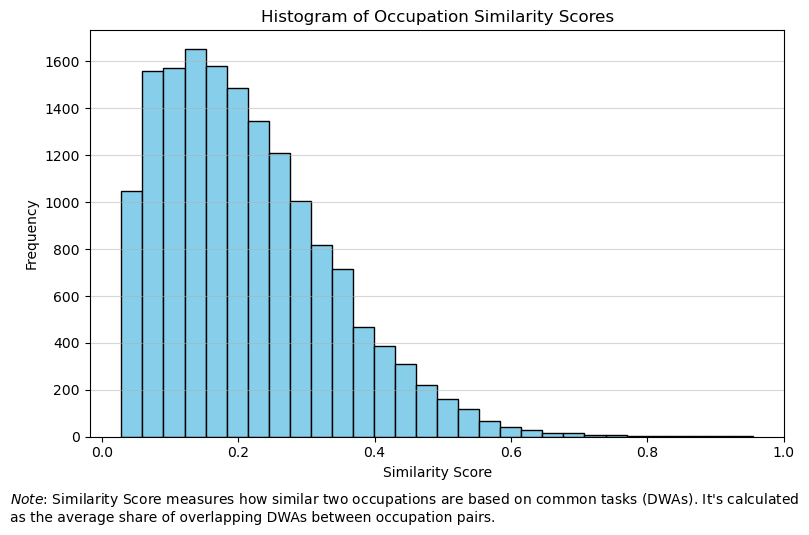

In [237]:
plt.figure(figsize=(8, 5))
plt.hist(similarity_df['similarity_score'], bins=30, color='skyblue', edgecolor='black')

plt.title('Histogram of Occupation Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)

caption = (r"$Note$: Similarity Score measures how similar two occupations are based on common tasks (DWAs). "
           "It's calculated as the average share of overlapping DWAs between occupation pairs.")
plt.figtext(0, -0.05, caption, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.show()

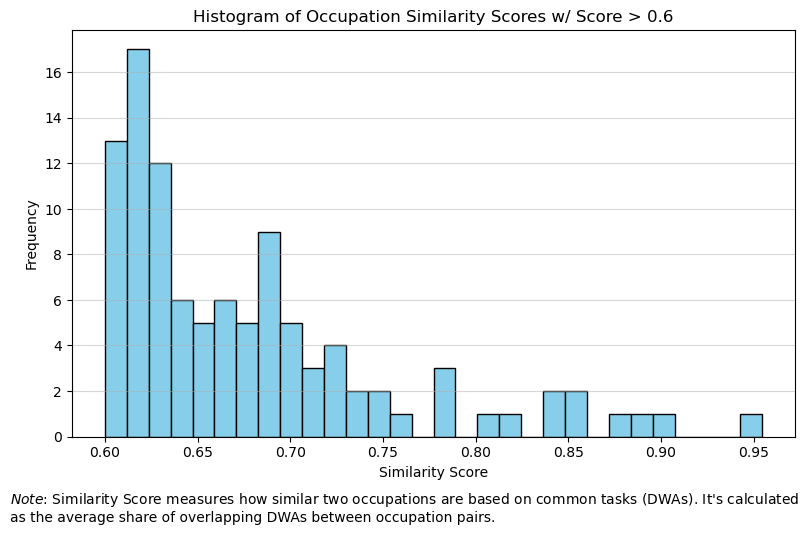

In [238]:
score_threshold = 0.6
high_similarity_df = similarity_df[similarity_df['similarity_score'] > score_threshold].reset_index(drop=True)

plt.figure(figsize=(8, 5))
plt.hist(high_similarity_df['similarity_score'], bins=30, color='skyblue', edgecolor='black')

plt.title(f'Histogram of Occupation Similarity Scores w/ Score > {score_threshold}')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)

caption = (r"$Note$: Similarity Score measures how similar two occupations are based on common tasks (DWAs). "
           "It's calculated as the average share of overlapping DWAs between occupation pairs.")
plt.figtext(0, -0.05, caption, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.show()

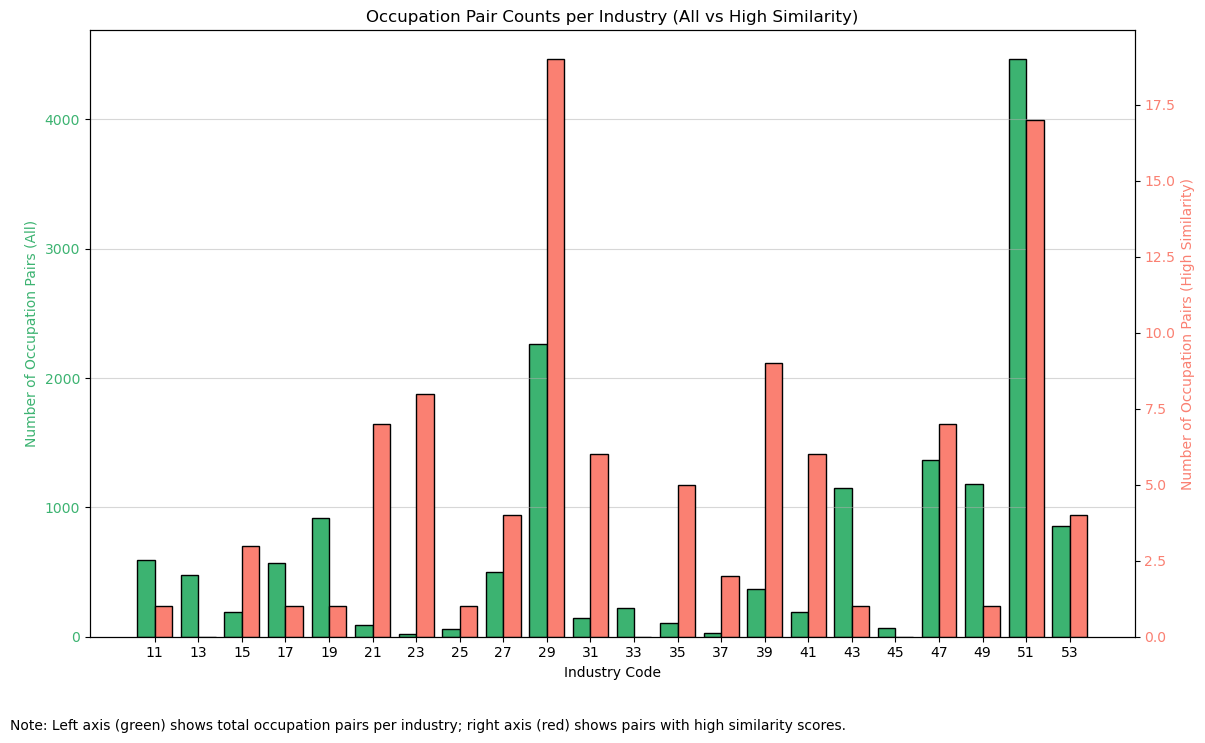

In [245]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# Counts from similarity_df
pair_counts_all = similarity_df['ind'].value_counts().sort_index()

# Counts from high_similarity_df (aligned)
pair_counts_high = high_similarity_df['ind'].value_counts().reindex(pair_counts_all.index, fill_value=0)

ind = np.arange(len(pair_counts_all))
width = 0.4

# Left axis (All Pairs)
bars1 = ax1.bar(ind - width/2, pair_counts_all, width, label='All Pairs', 
                color='mediumseagreen', edgecolor='black')
ax1.set_xlabel('Industry Code')
ax1.set_ylabel('Number of Occupation Pairs (All)', color='mediumseagreen')
ax1.tick_params(axis='y', labelcolor='mediumseagreen')

# Right axis (High Similarity)
ax2 = ax1.twinx()
bars2 = ax2.bar(ind + width/2, pair_counts_high, width, label='High Similarity Pairs', 
                color='salmon', edgecolor='black')
ax2.set_ylabel('Number of Occupation Pairs (High Similarity)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Titles and grids
plt.title('Occupation Pair Counts per Industry (All vs High Similarity)')
ax1.set_xticks(ind)
ax1.set_xticklabels(pair_counts_all.index)
ax1.grid(axis='y', alpha=0.5)

# Caption
caption = ("Note: Left axis (green) shows total occupation pairs per industry; "
           "right axis (red) shows pairs with high similarity scores.")
plt.figtext(0, -0.05, caption, wrap=True, horizontalalignment='left', fontsize=10)

fig.tight_layout()
plt.show()

In [240]:
# Occupations selected
top_occ_11 = similarity_df[similarity_df['ind'] == '11'].iloc[0]
occ1_code, occ2_code = top_occ_11['occ_a'], top_occ_11['occ_b']

# Get occupation titles
occ1_title = onet.loc[onet['occ_code'] == occ1_code, 'occ_title'].iloc[0]
occ2_title = onet.loc[onet['occ_code'] == occ2_code, 'occ_title'].iloc[0]

# Fetch tasks (dwa_id and dwa_title) for each occupation
tasks_occ1 = onet[(onet['ind'] == '11') & (onet['occ_code'] == occ1_code)][['dwa_id', 'dwa_title']].drop_duplicates()
tasks_occ2 = onet[(onet['ind'] == '11') & (onet['occ_code'] == occ2_code)][['dwa_id', 'dwa_title']].drop_duplicates()

# Identify common tasks
common_ids = set(tasks_occ1['dwa_id']).intersection(tasks_occ2['dwa_id'])
common_tasks = tasks_occ1[tasks_occ1['dwa_id'].isin(common_ids)]

# Identify unique tasks
unique_occ1 = tasks_occ1[~tasks_occ1['dwa_id'].isin(common_ids)]
unique_occ2 = tasks_occ2[~tasks_occ2['dwa_id'].isin(common_ids)]

# Create common tasks df
common_df = pd.DataFrame({
    f'{occ1_code} ({occ1_title}) dwa_id': common_tasks['dwa_id'].values,
    f'{occ1_code} ({occ1_title}) dwa_title': common_tasks['dwa_title'].values,
    f'{occ2_code} ({occ2_title}) dwa_id': common_tasks['dwa_id'].values,
    f'{occ2_code} ({occ2_title}) dwa_title': common_tasks['dwa_title'].values,
})

# Create unique tasks df without padding
unique_occ1_df = pd.DataFrame({
    f'{occ1_code} ({occ1_title}) dwa_id': unique_occ1['dwa_id'].values,
    f'{occ1_code} ({occ1_title}) dwa_title': unique_occ1['dwa_title'].values,
})

unique_occ2_df = pd.DataFrame({
    f'{occ2_code} ({occ2_title}) dwa_id': unique_occ2['dwa_id'].values,
    f'{occ2_code} ({occ2_title}) dwa_title': unique_occ2['dwa_title'].values,
})

# Concatenate unique dfs horizontally, handle different lengths
max_len = max(len(unique_occ1_df), len(unique_occ2_df))
unique_occ1_df = unique_occ1_df.reindex(range(max_len))
unique_occ2_df = unique_occ2_df.reindex(range(max_len))
unique_df = pd.concat([unique_occ1_df, unique_occ2_df], axis=1)

# Final dataframe (common on top, unique below)
final_df = pd.concat([common_df, unique_df], ignore_index=True)

# Remove any fully NaN rows
final_df = final_df.dropna(how='all').reset_index(drop=True)

# Add new column with number of common DWAs
final_df['num_common_dwas'] = len(common_tasks)

# Display final df
final_df

,11-3111 (Compensation and Benefits Managers) dwa_id,11-3111 (Compensation and Benefits Managers) dwa_title,11-3121 (Human Resources Managers) dwa_id,11-3121 (Human Resources Managers) dwa_title,num_common_dwas
0,4.A.1.a.1.I21.D04,Investigate industrial or transportation accid...,4.A.1.a.1.I21.D04,Investigate industrial or transportation accid...,19
1,4.A.1.a.1.I23.D01,"Interview employees, customers, or others to c...",4.A.1.a.1.I23.D01,"Interview employees, customers, or others to c...",19
2,4.A.2.a.2.I03.D01,Compile operational data.,4.A.2.a.2.I03.D01,Compile operational data.,19
3,4.A.2.a.4.I07.D11,Analyze data to inform personnel decisions.,4.A.2.a.4.I07.D11,Analyze data to inform personnel decisions.,19
4,4.A.2.b.1.I08.D03,Estimate labor requirements.,4.A.2.b.1.I08.D03,Estimate labor requirements.,19
5,4.A.2.b.3.I01.D08,Maintain knowledge of current developments in ...,4.A.2.b.3.I01.D08,Maintain knowledge of current developments in ...,19
6,4.A.3.b.6.I08.D10,Maintain personnel records.,4.A.3.b.6.I08.D10,Maintain personnel records.,19
7,4.A.3.b.6.I14.D02,Prepare reports related to compliance matters.,4.A.3.b.6.I14.D02,Prepare reports related to compliance matters.,19
8,4.A.4.a.2.I03.D09,Liaise between departments or other groups to ...,4.A.4.a.2.I03.D09,Liaise between departments or other groups to ...,19
9,4.A.4.a.2.I11.D09,Represent the organization in external relations.,4.A.4.a.2.I11.D09,Represent the organization in external relations.,19
